In [46]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

Weak learner 0 R^2: -21.86595826514709
Weak learner 20 R^2: -0.0026192923008196978
Weak learner 40 R^2: -0.0016748172727343302
Weak learner 60 R^2: -0.0014818633549413818
Weak learner 80 R^2: -0.0012578370480087475
Weak learner 100 R^2: -0.0007136861925911564


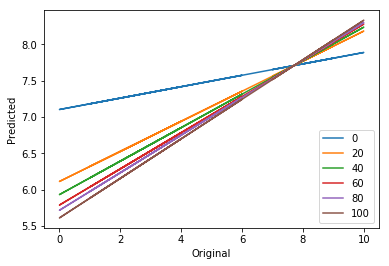

Overall R^2:
0.5282873581794295


In [47]:
# Working with the European Social Survey data again.
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
y = df['happy']
X = df.loc[:, ~df.columns.isin(['happy', 'cntry'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['happy'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df['happy'], predicted)[0, 1])

One strongish learner R^2: 0.06711108322936521


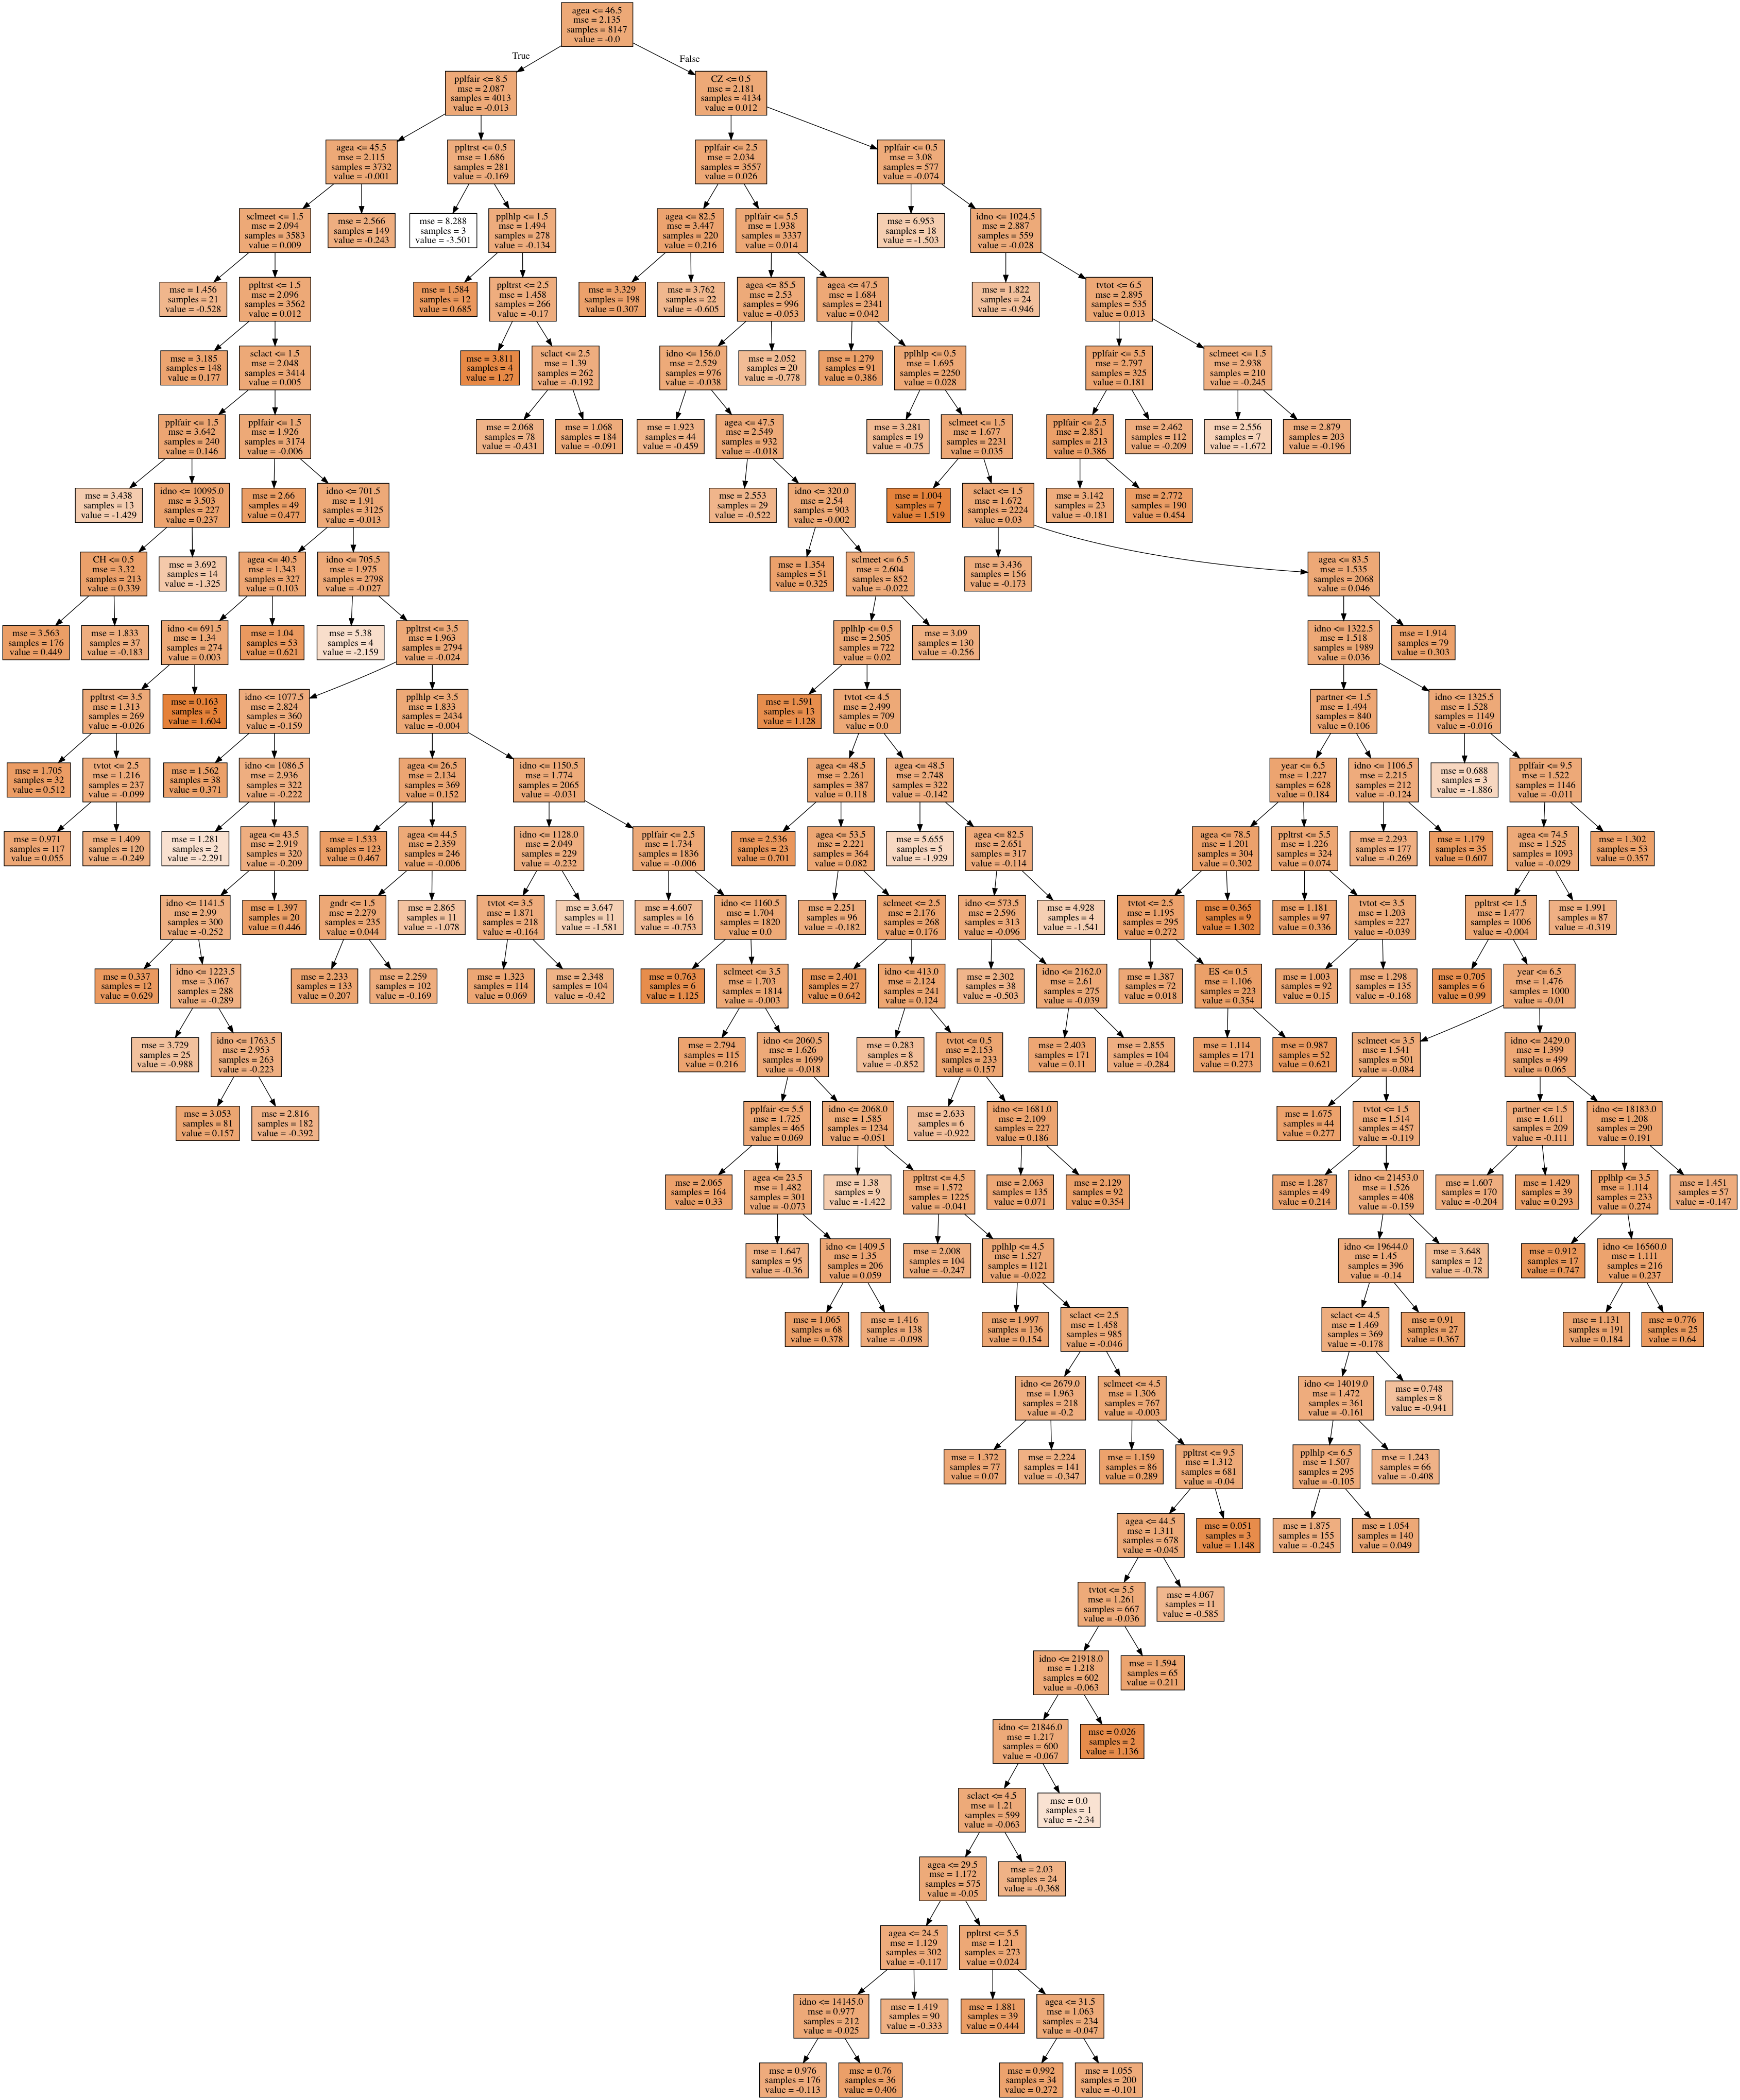

In [48]:
# One big tree. Each node split will include at lest 2.5% of the total sample.
decision_tree = tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree.fit(X,y)

#Get and store predicted values.
pred = decision_tree.predict(X)
print('One strongish learner R^2: {}'.format(decision_tree.score(X, y)))

dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,  
                                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

In [69]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [70]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [71]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


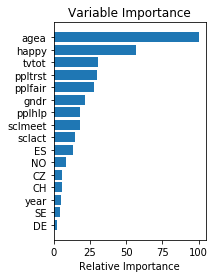

In [72]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Try age as a binary

In [74]:
df[['agea', 'happy']].describe()

,agea,happy
count,8147.000000,8147.000000
mean,47.262182,7.708482
std,18.316890,1.720839
min,15.000000,0.000000
25%,33.000000,7.000000
50%,47.000000,8.000000
75%,61.000000,9.000000
max,114.000000,10.000000


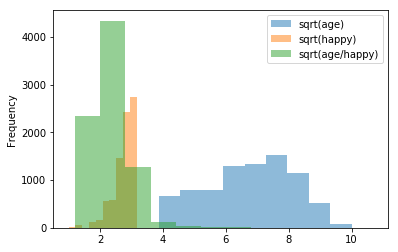

In [93]:
(df.agea ** .5).plot.hist(alpha=.5)
(df.happy[df.happy > 0]**.5).plot.hist(alpha=.5)
np.sqrt((df.agea+1) / (df.happy+1)).plot.hist(alpha=.5)
plt.legend(['sqrt(age)', 'sqrt(happy)', 'sqrt(age/happy)'])

In [94]:
df['senior'] = pd.get_dummies(df['agea'] > 65, drop_first=True)

In [95]:
df['joyful'] = pd.get_dummies(df['happy'] >= 8, drop_first=True)

In [108]:
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'senior', 'joyful'])]

In [109]:
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

In [110]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1

# Create training and test sets.
offset = int(X.shape[0] * 0.7)

# Put 70% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 30% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [112]:
# We'll make 1000 iterations, use 5-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 5,
          'loss': 'exponential',
          'learning_rate': 0.001,
         }

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



Training set accuracy:
Percent Type I errors: 0.01578393546124167
Percent Type II errors: 0.21483689933356717

Test set accuracy:
Percent Type I errors: 0.026993865030674847
Percent Type II errors: 0.2392638036809816


# To reduce the type 1 error in the test set by changing training split to 70%, reducing the learning rate to 0.001 and increasing the number of estimators to 1000, and changing the loss function to exponential